# K-Armed Bandit Problems 

First notebook of the series on Reinforcement Learning (RL). This notebook (along with the rest of the reinforcement learning series) is based on [this introductory book](http://incompleteideas.net/book/bookdraft2018jan1.pdf) by R.S. Sutton and A.G Barto and on this [coursera cource](https://www.coursera.org/learn/fundamentals-of-reinforcement-learning/home/welcome). The reason I created these notebooks is mainly to gain a better understanding of RL myself and to try and implement the theory and models with python.

### Load the required libraries

In [1]:
import numpy as np
import gym
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from tqdm import tqdm 
from gym import spaces
from gym.utils import seeding

import time 

In [2]:
%matplotlib inline

## What are the K-Armed Bandits?

In K-Armed Bandits there is one ***state** and k-**actions** for an **agent** to interact within an **environment***. Every action provides a (random) reward with an unknown value. The goal of the agent is to maximise the reward in the long run and to do so, the agent needs to explore all the actions and find the one that generates the highest reward. 

Based on the definition above, I will start building the structure of the environment using the **OpenAI**'s gym interface. The blocks of code below are highly influenced by [this code](https://github.com/diegoalejogm/openai-k-armed-bandits/tree/master/gym_armed_bandits).

In [3]:
m = np.array([[5, 1, 0, -10]]) # means for a 4-armed bandit 
sd = np.array([[1, 0.1, 5, 1]]) # standard deviations for a 4-armed bandit 
bandit_len = len(m[0]) # number of bandits 
# a = np.array([[1]]) # actions for a 4-armed bandit, play around with indecies: 0-3

## Building the structure of the environment 

The environment will receive ```np.array()``` for means and standard deviations for each action with dimensions ```num_experiments x num_bandits```. For the 4-armed bandit the action indecies should be from 0-3 (one at a time). 

### sample from the specified bandit and take steps. 

The size of the vector for each step is of size ```num_experiments```, where the action to take is specified for each experiment. As a return we get ```r``` which is the reward for each experiment/action 

In [88]:
class BanditsEnv():
    
    '''Here, we get an array of length k. Each item is a function which samples 
    from a specified distribution.'''
    
    metadata = {'render.mode': ['human']}
    
    def __init__(self, m, sd, exp):
        
        assert len(m.shape) == 2
        assert len(sd.shape) == 2
        
        super().__init__()
        
        # define action and obs spaces
        self.mean = m
        self.sd = sd
        self.nb_bandits = len(m[0]) # number of bandits 
        self.nb_exp = exp # number of experiments 
        self.action_space = spaces.Discrete(self.nb_bandits) # define action space
        self.obs_space = spaces.Discrete(1) # define observetional space
    
    # define the step function  
    def step(self, a):
        
        # input arg: array that contains the current action 
        # output: reward array for the current action 
        
        assert (a < self.nb_bandits).all()
        # assert self.action_space.contains(a) # assert action is valid
        
        sampled_m = self.mean[np.arange(self.nb_exp), a]
        sampled_sd = self.sd[np.arange(self.nb_exp), a]
        
        if self.nb_exp == 1: # if we only have one experiment 
            r = np.random.normal(loc=sampled_m, scale=sampled_sd, size=(self.nb_exp, self.nb_exp,))
        else:
            r = np.random.normal(loc=sampled_m, scale=sampled_sd, size=(self.nb_exp, ))
        
        # for now return only reward 
        return r     
    
    def reset(self):
        # is reseting a desired behaviour?
        return 0
    
    def render(self, mode='human', close=False):
        pass
    
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        
        return [seed]

class BanditsGaussian(BanditsEnv):
    
    '''
    This class takes the Bandids environment as an input and allows us to create an environment with random
    mean rewards for every action'''
    
    def __init__(self, exp=1, n_bandits=3):
        self.means = np.random.normal(size=(exp, n_bandits))
        
        BanditsEnv.__init__(self, self.means, np.ones((exp, n_bandits)), exp)

### Creating and interacting with the environment 
Now let's create an environment by passing arrays of the means and standard deviations as input arguments. Every time we interact with the environment we specify which bandid we want to pull, and the environment will return the associated reward

In [5]:
# create an environment 
n_exp = 1
test_env = BanditsEnv(m, sd, n_exp)
rewards = np.zeros(m.shape) # we'll store the rewards here

# get the reward for each action
for i in range(4):
    a = np.array([[i]])
    r = test_env.step(a)
    rewards[0,i] = r
    print(" reward for bandit", i+1, "was:", r[0])

 reward for bandit 1 was: [3.9189569]
 reward for bandit 2 was: [1.06985915]
 reward for bandit 3 was: [-0.37143946]
 reward for bandit 4 was: [-11.58608682]


Above I created 4 bandits (with their means and sd). I interacted with each bandit to see the reward it returns. The reward looks random, however it seems that it falls near the mean of each bandit. The sd shows how far the rewards will fall for each bandit. For example, the deviation for the second bandit is very small (0.1) and we see that the reward is very close to the mean. The sd of the third bandit is high (5) and it seems that the reward always falls quit far from the mean.

#### Exercise and Practice 
This example has 4 bandits. Play around with the Environment and try running it with more bandits (e.g. 6 or 10) or change the means and standard deviations.

### The exploration - Explotation Dilemma
Note that interacting with each bandit just once doesn't tell us much. The goal in such tasks is to interact with the environment many times, explore all actions/bandits and build a distribution of rewards for each action/bandit, in an attempt to choose an action that gives the highest reward.

This notion is very familiar in situations from real life. Imagine being at a restaurant and trying to choose between ordering a meal that you have tried before and you know is good (previous high reward) or ordering a meal that is new but looks delicious. What should you choose? You know that the familiar meal will give you a high reward, but what if the new meal is even tastier? 

Choosing the familiar meal is a greedy behaviour because you already know that this choice will give you high reward (exploitation), however, it stops you from trying other options (exploration). This is called the exploration-explotation dilemma and is a very common problem in k-armed bandit tasks. The dilemma is presented every time the agent is in an **uknown or partially known** environment and trys to optimise its interaction with the environment. The agent wants to get the highest possible reward but does not know which action is the best for achieving this goal. By exploring (trying different actions or trying different meals every time we go to a specific restaurant), we interact with the environment, we learn more about it but we also sacrifice the chance of getting a known (high reward). This may look sub-optimal, but, **in the long run** new actions may give higher rewards than we initially thought.

This dilemma is very common in RL situations, thus developing good strategies for dealing with it is very important.

Before developing the strategies we should first see how we can evaluate our actions. 

### Evaluating actions

Now that we have developed our environment, let us evaluate our actions. For each of the 4 arms/actions we need a value of what we expect to get from the given action. In the beginning, we do not know what to expect, however, every time we interact with the environment (every time we take an action) we update our expectations.

I will start by interacting with the environment 5 times. And during each interaction, I will be storing the first action reward values to a list. For this behaviour, I will receive a list of rewards ```first_a```:

In [7]:
eval_env = BanditsEnv(m, sd, n_exp)
first_a = []
s = 4 # nubmer of bandit arms/actions to take
n = 5 # number of steps (times we interact with the environment)

# get the reward for each action n times (n pulls) and store the reward values for the first action in a list
for i in range (n):
    rewards = np.zeros(m.shape) # for every pull, we'll store the rewards here
    
    for j in range(s):
        a = np.array([[j]])
        r = eval_env.step(a)
        rewards[0,j] = r
        
    first_a.append(rewards[0,0]) # store the actions for the 1st action/arm

first_a # visualise     

[4.502612336867675,
 4.192138699330854,
 4.691527842326976,
 3.9881987247873933,
 5.292556271865549]

The expected value for the first action is the average of all values of that action. This is how we calculate the expected value for a given action: 


$$Q_{n}\dot{=}\frac{R_{1}+R_{2}+...+R_{n}}{n}$$

So, now that we have the formula, let us calculate the expected reward value:

In [8]:
Q_first = sum(first_a)/len(first_a)
Q_first

4.533406775035689

We could also write the above code as: ```Q_first = np.asarray(first_a).mean()```

If we pull the arm/action again (n + 1 times) we would need to average again, and if we pull it one more time we average again... this can become quite unpractical and the way to handle it is by adding an **update rule** into our formula to get a new combined average:
$$n = n + 1$$

$$Q_{n} = Q_{n+1}$$

$$Q_{n}\dot{=}Q_{n-1}+\frac{1}{n} [R_{n}-Q_{n-1}]$$

We do this for every action and we update the formula for each step we add. If we play around with the step size $\frac{1}{n}$ we will notice that this update rule starts converging as we increase the step size and this occurs because as n gets larger the value changes less:

In [9]:
rewards = np.zeros(m.shape) # for every pull, we'll store the rewards here

for j in range(s):
    a = np.array([[j]])
    r = eval_env.step(a)
    rewards[0,j] = r
    print(" reward for bandit", j+1, "was:", r[0])

first_a.append(rewards[0,0]) 
first_a # visualise 

 reward for bandit 1 was: [4.34184426]
 reward for bandit 2 was: [0.90417035]
 reward for bandit 3 was: [2.39566107]
 reward for bandit 4 was: [-9.16348044]


[4.502612336867675,
 4.192138699330854,
 4.691527842326976,
 3.9881987247873933,
 5.292556271865549,
 4.341844258094896]

In [10]:
Q_first = sum(first_a)/len(first_a)
Q_first

4.501479688878891

This is a simple way of incrementing steps and adding reward values. To (manually) visualise the convergence run the above to blocks of code a few times until ```Q_first``` srarts decreasing.

**Note**: To make our code cleaner and easier to read we can add the incremental part in a function. This function will do exactly what the last formula (with the updating rule does):

In [11]:
def incremental_rule(aval, m, n):
    
    # aval = (previous) average value
    # m = np array with means of k-arms
    # n = step size
    
    n = n + 1 # increment step size by 1
    rewards = np.zeros(m.shape)
    
    for j in range(s):
        a = np.array([[j]])
        r = eval_env.step(a)
        rewards[0,j] = r
        
    temp = rewards[0,0]
    upd_aver = aval + 1 / n * (temp - aval)
    return upd_aver, n

In [74]:
Q_first, n = incremental_rule(Q_first, m, n)   
Q_first

5.04166455639066

## Exploitation - The Greedy Agent 

As mentioned earlier, there are two startegies for choosing the best action each time. The agent can either exploit or explore actions and their rewards. 

I will focus on exploitation for now. In k-armed badint problems the optimal behaviour is that the agent chooses the action that gives the best reward in the long run. The agent needs to interact with the environment in order to learn. However, there might be times that the agent is **greedy**, that is, he does not choose to explore all actions and reward values, but chooses the action that gives the current maximum expected value. Think of this behaviour like going to a nice restaurant and choosing one specific meal every single time, because you ordered it once and you liked it. But this kind of behaviour does not let you explore other choises. 

This is exploitation and when an agent chooses greedy actions we use the ```argmax()``` function of the expected values. In cases of exploitation, if more than one action is considered best, then the agent chooses one of these best choices randomly. This refers to breaking ties between multiple max elements so that the first element only is returned. We are goint to use the ```np.argmax()``` function to do that. Let's built **our** ```argmax()``` function. 

We will generate a template with all the values in the input matrix that are equal to the max value. We will then generate some noise and lastly we will multiply the noise array with the template and use the np.argmax method to get the indices of the maximum values:

In [75]:
def argmax(mat):
    
    '''
    Input: N x k matrix with reward estimates 
    Output: array with index of the item(s) with the (first) highest value per row in the matrix 
    
    Uses the np.argmax() function with tie breaking between multiple max elements.
    
    '''
    
    # first create the template:
    template = mat == mat.max(axis=1)[:, None]
    
    # generate some random noise:
    noise = 1e-6*np.random.random(mat.shape)
    
    # multiply the noise with the template values:
    temp_n = noise * template
    
    # get the argmax of the template using the np.argmax() function. This will return only the 
    # first max element in case there are more than 1
    outmat = np.argmax(temp_n, axis=1)
    
    return outmat

The next step requires creating our ```GreedyAgent``` class. The agent will be learn to interact with the Env that we created earlier. The agent takes an action based on based on which action returns the highest reward but it can also learn from the action that it chose by updating the values for each action using the incremental averaging rule.

In [76]:
class GreedyAgent:
    
    def __init__(self, e, b):
        
        '''
        The Greedy Agent takes the number of experiments and bandits as input and updates the estimates of 
        the reward incrementally whenever the agent interacts with the environment
         
         INPUTS:
         e = number of experiments
         b = number of bandits 
        
        '''
        
        estimates = np.zeros((e, b))
        
        self.nbandits = b
        self.nexperiments = e
        self.estimates = estimates.astype(np.float64) 
        self.a_count = np.zeros(self.estimates.shape)
        
    def greedy_action(self):
        
        # we'll just use the argmax function:
        max_action = argmax(self.estimates)
        
        # if an action in self.a_count is selected (for having the highest value), add the value of 1
        self.a_count[np.arange(self.nexperiments), max_action] += 1
        ac = self.a_count
        estm = self.estimates
        
        return max_action, ac, estm
    
    def estimate_upd(self, r, a):
    
        '''
        Input arguments:
        r = reward,
        a = (max) actions
    
        Output: updated reward estimates 
    
        We use this function to update the reward estimates incrementally '''
    
        n = self.a_count[np.arange(self.nexperiments), a]
    
        # difference between received rewards and reward estimates 
        e = r - self.estimates[np.arange(self.nexperiments), a]
    
        # update the reward diff incrementally
        self.estimates[np.arange(self.nexperiments), a] += (1/n) * e
        act_estimates = self.estimates
    
        return act_estimates   

### Environment - Agent interaction
So, how do we expect our agent to behave? At first it wont have much knowledge of the environemnt, so it will expect that each action is the same. After interacting with the environment a few times it should start learning and differentiating between actions and their rewards. However, it may also keep choosing the action that gives the highest reward (over, and over) until the action stops providing high reward.

**Is the second a good strategy?**

Now that we created the environment and the agent let us test how it behaves. We will see how the agent estimates the values for each action as well as the real values provided by the environment. 

In [77]:
exp = 2
n_bandits = 4
n_steps = 10
m = np.random.normal(size=(exp, n_bandits))
sd = np.ones((exp, n_bandits))

# Create a new env and init the agent 
env = BanditsEnv(m, sd, exp)
agent = GreedyAgent(exp, n_bandits)

In [78]:
# now that we have our environment and agent, it's time for the interaction between them. we'll add a loop 
# and the interaction will take place n_steps times:
estimates = []
for i in range(n_steps):
    max_action, action_count, estim = agent.greedy_action() # max action chosen by the agent
    reward = env.step(max_action) # get reward for that action
    temp = agent.estimate_upd(reward, max_action)
    estimates.append(temp)
    
# estimates 

In [ ]:
class BanditsGaussian(BanditsEnv):
    
    '''
    This class takes the Bandids environment as an input and allows us to create an environment with random
    mean rewards for every action'''
    
    def __init__(self, exp=1, n_bandits=3):
        self.means = np.random.normal(size=(exp, n_bandits))
        
        BanditsEnv.__init__(self, self.means, np.ones((exp, n_bandits)))

If we increase the number of steps and visualise the estimated vs real reward values, we will see that most of the times the agent does not explore the actions, but sticks on the one that returns the highest reward. 
This is definitely not an optimal behaviour. Let's visualise it this time using the ```BanditsGaussian()``` environment. We will plot how many times (%) the agent chose the optimal action of *n* experiments:

In [162]:
# define initial variables
exp = 100 # number of experiments
n_steps = 1000 # number of steps 
n_bandits = 6 # numebr of actions 

# initialise variables of scrores and averages for storing and ploting:
avg = np.zeros((n_steps))
best = np.zeros((n_steps))
score = np.zeros((exp, n_steps+1))

In [163]:
# create the environment
env = BanditsGaussian(exp, n_bandits)
agent = GreedyAgent(exp, n_bandits)

# best actions?
best_action = np.argmax(env.mean, axis=1)

In [164]:
# within a tqdm loop select actions to execute on the env 
for i in tqdm(range(n_steps)):
    max_action, _, _ = agent.greedy_action()
    reward = env.step(max_action) # get reward
    
    # update the estimates with the newly obdained rewards
    agent.estimate_upd(reward, max_action)
    
    # update score, average and best variables:
    score[:,i+1] = score[:,i] + reward
    avg_score = np.mean(score[:,i+1]/(i+1))
    avg[i] = avg_score
    
    # get best actions from the env
    tmp = np.mean(max_action == best_action)
    best[i] = tmp

100%|██████████| 1000/1000 [00:00<00:00, 5373.60it/s]


We can now plot the optimality (averaged across experiments) of our **greedy agent**. This means that we will plot the % of best actions taken for every step:

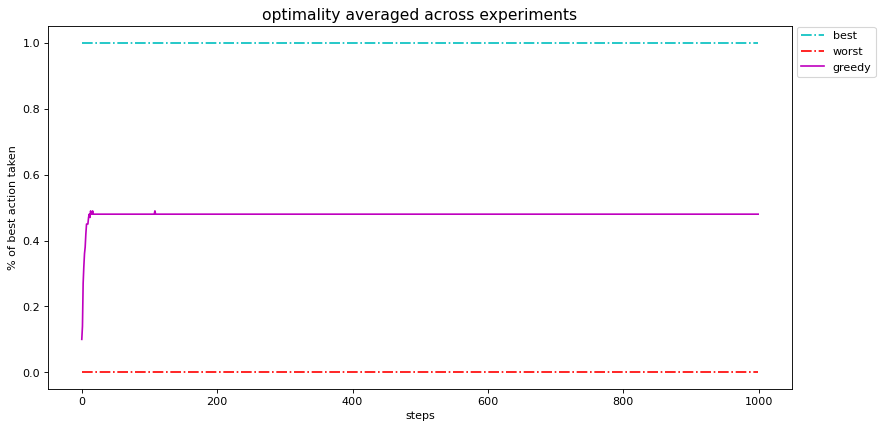

In [171]:
plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot([1 for i in range(n_steps)], linestyle='-.', color='c')
plt.plot([0 for i in range(n_steps)], linestyle='-.', color='r')
plt.plot(best, color='m')
plt.legend(['best', 'worst', 'greedy'], bbox_to_anchor=(1.12, 0.93), loc='right')
plt.title('optimality averaged across experiments', fontsize=14)
plt.ylabel('% of best action taken')
plt.xlabel('steps')
plt.show()

Our (greedy) Agent chooses the best action approximately 50% of the times. Thus the greedy agent is not the best strategy for finding the optimal actions